<a href="https://colab.research.google.com/github/Abhishek734/Deep-learning-practice/blob/master/cat-dog/vgg16_model_for_cat_dog_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Library

In [0]:
import numpy as np
import pandas as pd
import os
import random
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from keras.preprocessing.image import load_img


## Load the data from kaggle

In [0]:
# from google.colab import files
# files.upload()

# Let's make sure the kaggle.json file is present.
# !ls -lha kaggle.json

# Next, install the Kaggle API client.
# !pip install -q kaggle

# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

# Copy the stackoverflow data set locally.
# accept the terms and conditions 
!kaggle competitions download -c dogs-vs-cats

from zipfile import ZipFile

filename='train.zip'
with ZipFile(filename,'r') as zip:
  zip.extractall()
  print('done!')

filename='test1.zip'
with ZipFile(filename,'r') as zip:
  zip.extractall()
  print('done!')

sampleSubmission.csv: Skipping, found more recently modified local copy (use --force to force download)
test1.zip: Skipping, found more recently modified local copy (use --force to force download)
train.zip: Skipping, found more recently modified local copy (use --force to force download)
done!
done!


## Prepare Training Data

In [0]:
filenames = os.listdir("train")
categories = []
for filename in filenames:
    category = filename.split(".")[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [0]:
df.head()

,filename,category
0,dog.10039.jpg,1
1,cat.3790.jpg,0
2,dog.5107.jpg,1
3,dog.10857.jpg,1
4,cat.8446.jpg,0


## See total counts

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_core.py:185: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


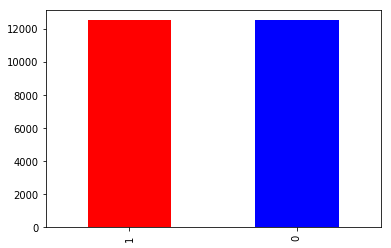

In [0]:
df['category'].value_counts().plot.bar(colors = ("red","blue"))

## lets see a sample data

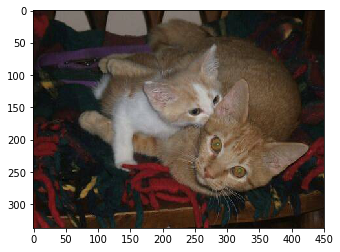

In [0]:

sample_img = random.choice(filenames)
img = load_img("train/" + sample_img)
plt.imshow(img)

## Building VGG16 model with classifier


In [0]:
FAST_RUN = False
IMAGE_WIDTH=224
IMAGE_HEIGHT=224
IMAGE_CHANNELS=3
input_shape = (IMAGE_WIDTH,IMAGE_HEIGHT,IMAGE_CHANNELS)

In [0]:
from keras.models import Sequential
from keras.applications import VGG16
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras import optimizers, layers
from keras.models import Model

pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights='imagenet')


for layer in pre_trained_model.layers[:15]:
    layer.trainable = False

for layer in pre_trained_model.layers[15:]:
    layer.trainable = True

last_layer = pre_trained_model.get_layer("block5_pool")
last_output = last_layer.output
#Flatten
x = GlobalMaxPooling2D()(last_output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)

x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)

model.compile(loss="binary_crossentropy",
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=["accuracy"]
              )

model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [0]:
pre_trained_model.layers

## Callbacks

In [0]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

## Early Stop

To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased

In [0]:
earlystop = EarlyStopping(patience=10)

## Learning Rate Reduction

We will reduce the learning rate when then accuracy not increase for 2 steps

In [0]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [0]:
callbacks = [earlystop, learning_rate_reduction]

## Data Preparation

Because we will use image genaretor with **class_mode="categorical"**. We need to convert column category into string. Then imagenerator will convert it one-hot encoding which is good for our classification.


So we will convert 1 to dog and 0 to cat


In [0]:
df["category"] = df["category"].replace({0:'cat', 1:'dog'})

In [0]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [0]:
print(validate_df.shape)
print(train_df.shape)

(5000, 2)
(20000, 2)


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_core.py:185: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


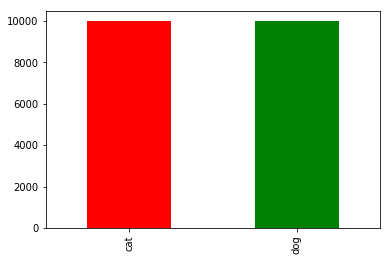

In [0]:
train_df['category'].value_counts().plot.bar(colors = ['red','green'])

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_core.py:185: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


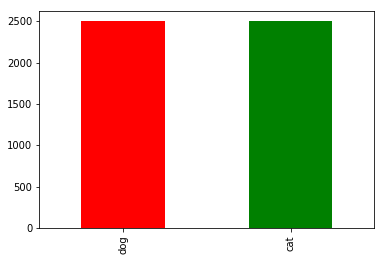

In [0]:
validate_df['category'].value_counts().plot.bar(colors = ['red','green'])


In [0]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

## Training Generator

In [0]:
# datagen = ImageDataGenerator(
#         featurewise_center=False,  # set input mean to 0 over the dataset
#         samplewise_center=False,  # set each sample mean to 0
#         featurewise_std_normalization=False,  # divide inputs by std of the dataset
#         samplewise_std_normalization=False,  # divide each input by its std
#         zca_whitening=False,  # apply ZCA whitening
#         rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
#         zoom_range = 0.0, # Randomly zoom image 
#         width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
#         height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
#         horizontal_flip=False,  # randomly flip images
#         vertical_flip=False)  # randomly flip images

# datagen.fit(X_train)
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "train/", 
    x_col='filename',
    y_col='category',
    target_size=(IMAGE_WIDTH,IMAGE_HEIGHT),
    class_mode='binary',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


## Validation generator

In [0]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "train/", 
    x_col='filename',
    y_col='category',
    target_size=(IMAGE_WIDTH,IMAGE_HEIGHT),
    class_mode='binary',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


In [0]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "train/", 
    x_col='filename',
    y_col='category',
    target_size=(IMAGE_WIDTH,IMAGE_HEIGHT),
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


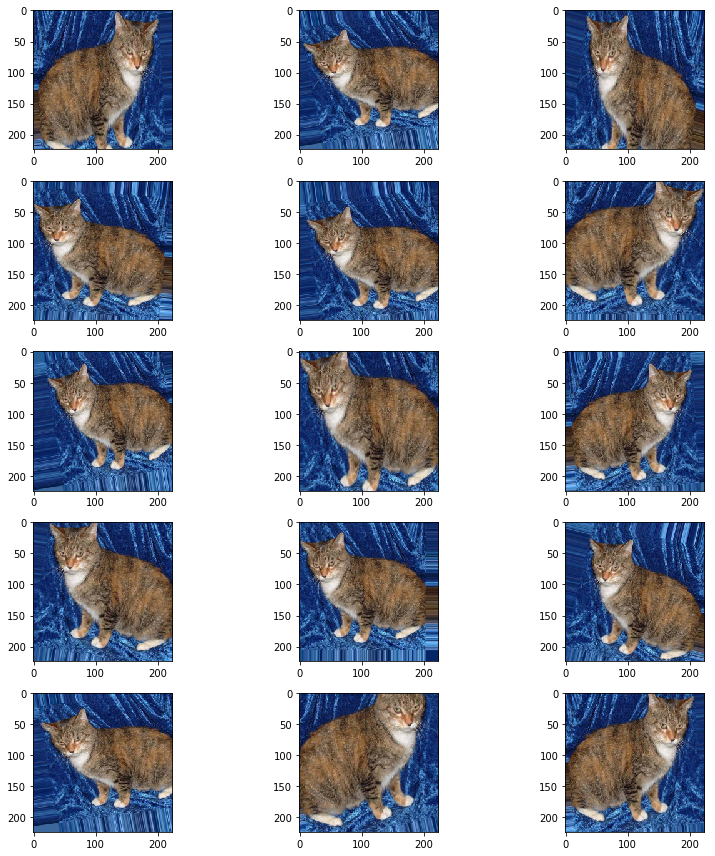

In [0]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

# lets fit our model

In [0]:
batch_size =16
epochs = 5

In [0]:
# fine-tune the model
history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size)

Epoch 1/5
1250/1250 [==============================] - 267s 214ms/step - loss: 0.3243 - acc: 0.8458 - val_loss: 0.1389 - val_acc: 0.9463
Epoch 2/5
1250/1250 [==============================] - 263s 211ms/step - loss: 0.1582 - acc: 0.9355 - val_loss: 0.1112 - val_acc: 0.9541
Epoch 3/5
1250/1250 [==============================] - 263s 210ms/step - loss: 0.1347 - acc: 0.9436 - val_loss: 0.1318 - val_acc: 0.9454
Epoch 4/5
1250/1250 [==============================] - 262s 210ms/step - loss: 0.1162 - acc: 0.9536 - val_loss: 0.0973 - val_acc: 0.9593
Epoch 5/5
1250/1250 [==============================] - 262s 210ms/step - loss: 0.1050 - acc: 0.9568 - val_loss: 0.0858 - val_acc: 0.9673


In [0]:
loss, accuracy = model.evaluate_generator(validation_generator, total_validate//batch_size, workers=12)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

Test: accuracy = 0.967348  ;  loss = 0.085182 


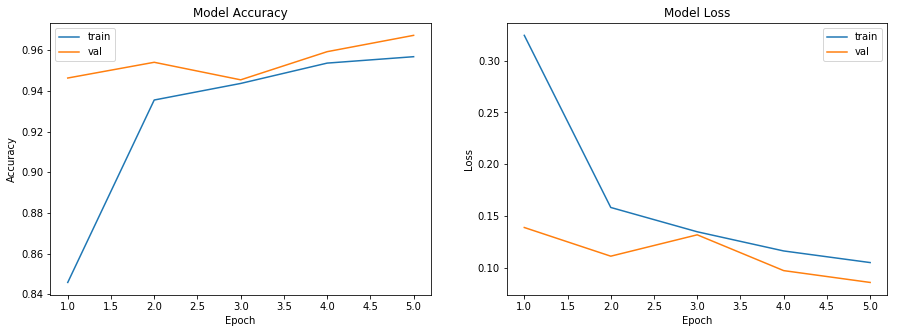

In [0]:
def plot_model_history(model_history, acc='acc', val_acc='val_acc'):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].plot(range(1,len(model_history.history[acc])+1),model_history.history[acc])
    axs[0].plot(range(1,len(model_history.history[val_acc])+1),model_history.history[val_acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history[acc])+1),len(model_history.history[acc])/10)
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()
    
plot_model_history(history)

In [0]:
validate_df["category"] = validate_df["category"].replace({ 'cat':0,  'dog':1}) 


Y_val = validate_df['category']
y_pred =  model.predict_generator(validation_generator)

In [0]:
threshold = 0.5
y_final = np.where(y_pred > threshold, 1,0)

In [0]:
y_final.size

5000

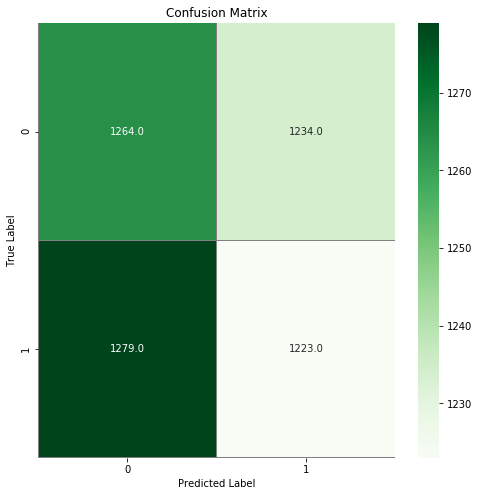

In [0]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Predict the values from the validation dataset

# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_val, y_final) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [0]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(Y_val, y_final, target_names=['0','1'])

print(report)

              precision    recall  f1-score   support

           0       0.50      0.51      0.50      2498
           1       0.50      0.49      0.49      2502

    accuracy                           0.50      5000
   macro avg       0.50      0.50      0.50      5000
weighted avg       0.50      0.50      0.50      5000



In [0]:
# Prepare Testing Data
test_filenames = os.listdir("test1/")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [0]:
# Create Testing Generator
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "test1/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    batch_size=batch_size,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    shuffle=False
)

Found 12500 validated image filenames.


In [0]:
# Predict

predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))
threshold = 0.5
test_df['category'] = np.where(predict > threshold, 1,0)

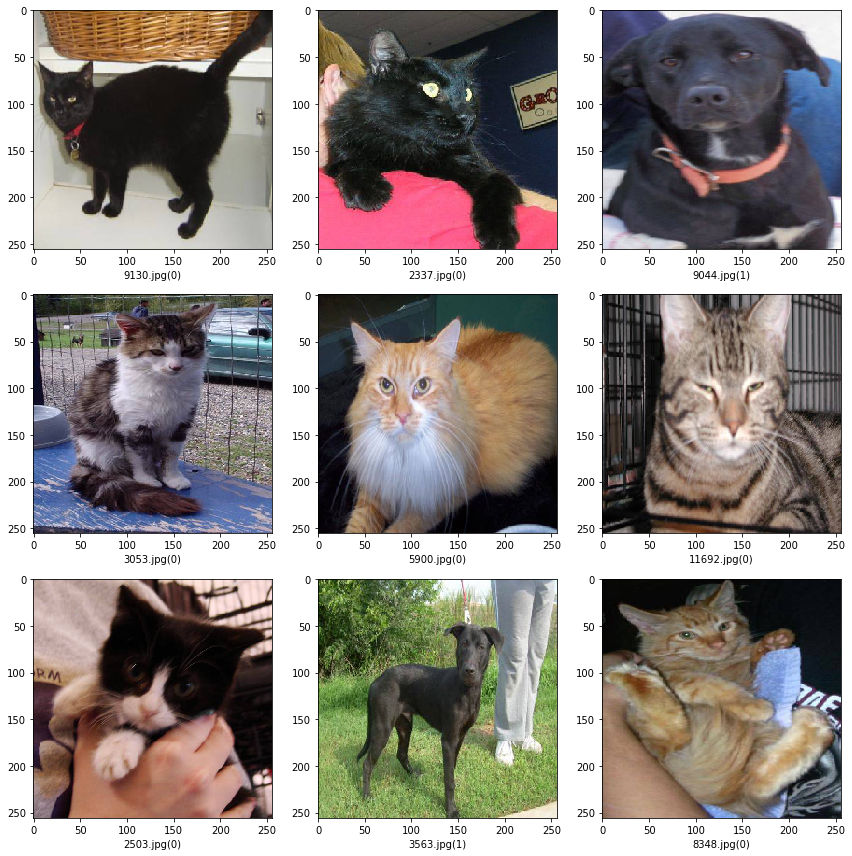

In [0]:
# lets see

sample_test = test_df.sample(n=9).reset_index()
sample_test.head()
plt.figure(figsize=(12, 12))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("test1/"+filename, target_size=(256, 256))
    plt.subplot(3, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')')
plt.tight_layout()
plt.show()

Text(0.5, 1.0, '(Test data)')

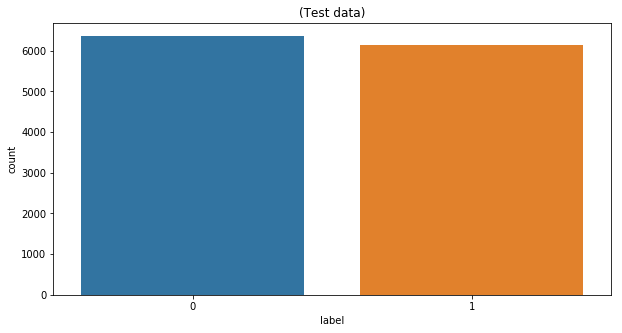

In [0]:
# subs
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission_13010030.csv', index=False)

plt.figure(figsize=(10,5))
sns.countplot(submission_df['label'])
plt.title("(Test data)")